In [1]:
%matplotlib inline
import numpy as np
import scipy 
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import interpolate

Falling particle test case
==========================================================


Particle settling chosen to examine correct evaluation and integration of fluid force over the particle.

According to drag law, the frictional force is given by:
$$
F_{D} =\frac{1}{2} \rho_{f} A_{p} C_D \mathbf{v_{r}}^2
$$ 

The difference between weight and buoyancy is:

$$
F_g = \left( m_p - \rho_f V_p \right) g = \left( \rho_p  - \rho_f \right) V_p g = m_r g
$$

Therefore, the net force is:
$$
F_{net} = m_r g - \frac{1}{2} \rho_{f} A_{p} C_D \mathbf{v_{r}}^2
$$

At equilibrium, net force is zero, then:
$$
v_r^{\infty} = \sqrt{\frac{2 m_r g}{\rho_f A C_D}}
$$

The Schiller & Naumann (1933) correlation provides the standard drag coefficient for spherical particles: 

$$
C_D = \max{ \left[ \frac{24}{Re} \left( 1 + 0.15 Re^{0.687} \right), 0.44 \right]}
$$

where the relative particle Reynolds number is given by:

$$
Re = \frac{\rho_{f} \left | {\mathbf{v} - \mathbf{u}} \right | d_{p}}{\mu_{f}} = \frac{\rho_{f} \left | \mathbf{v_r} \right | d_{p}}{\mu_{f}} 
$$

For a spherical particle in the Newtonian drag regime the drag on a sphere can be approximated by a constant, 0.44. This constant value implies that the efficiency of transfer of energy from the fluid to the particle is not a function of fluid velocity. As such the terminal velocity of a particle in a Newtonian regime can again be obtained by equating the drag force to the applied force, resulting in the following expression:

$$
v_{newtonian}^{\infty} = 2.46 \sqrt{\frac{\left( \rho_p - \rho_f \right) g d_p}{2 \rho_f}}
$$

For a spherical particle in the Stokes drag regime (low-Re flow regime) the drag can be modeled using Stokes drag law and:

$$
v_{stokes}^{\infty} = -\frac{1}{18} \frac{ \left( \rho_p - \rho_f \right) g d_p^2}{\mu_f}
$$

In order to get the transient velocity, considering that the particle moves only in y-diretion and the fluid is stagnant, the equation to be solved is:
$$
m_p \frac{dv}{dt} = m_r g - \frac{1}{2} \rho_{f} A_{p} C_D v^2
$$

Test definition
==========================================================



In [2]:
# general properties
g = 9.81 # [m/s²] in positive x direction

# particle properties
d_p = 0.0002 # [m]
rho_s = 2500.0 # [kg/m³]
A_p = np.pi * d_p ** 2.0 / 4.0 # [m²]
V_p = 4.0 / 3.0 * np.pi * (d_p / 2.0) ** 3.0 # [m³]

mass = rho_s * V_p # [kg]
print(mass)
#injection properties
len_inj = 0.0002 # [m]
wid_inj = 0.0002 # [m]
time_inj = 0.0001 # [s]
mass_flow_inj = mass/time_inj # [kg/s]
print(mass_flow_inj*1000*60*60, "g/h" )
mass_flow_ton = mass_flow_inj*60*60/1000 #[ton/h]
print(mass_flow_ton, "t/h")


1.0471975511965978e-08
376.9911184307752 g/h
0.0003769911184307752 t/h


In [3]:
# helper functions

def SchillerNaumann1933(Re):
    # calculates CD using SchillerNaumann
    part1 = (24.0/(Re+0.00000001)) * (1 + 0.15 * Re**(0.687))
    part2 = 0.44
    cd = max(part1,part2)
    return cd

def Stokes(Re):
    # calculates CD using Stokes
    cd = 24.0/(Re+0.00000000001)
    return cd

def NewtonianDragTerminalVelocity(rho_s, rho_f, g, d_p):
    # Calculate terminal velocity estimated for a newtonian drag regime
    vel = 2.46 * (((rho_s - rho_f) * g * d_p/2.0 / rho_f)**0.5)
    #vel = (4.0/6)*((rho_s - rho_f) * g * d_p / rho_f * 0.44) 
    return vel

def StokesTerminalVelocity(rho_s, rho_f, g, d_p, mu_f):
    velStokes = (1.0/18)* ( rho_s - rho_f)* g *d_p*d_p/mu_f
    return velStokes

def residual(v_inf):
    Re = rho_f * v_inf * d_p / mu_f
    if regime ==1:
        C_D = SchillerNaumann1933(Re)
    elif regime == 2:
        C_D = Stokes(Re)
    
    delta_v = 0.5 * rho_f * A_p * C_D * v_inf * v_inf - (rho_s - rho_f) * V_p * g
    
    return delta_v

def transient_velocity( vel, time, regime ):
    # Function to calculate velocity against time (to be numerically integrated)
    C1 = (g/rho_s)*(rho_s - rho_f)
    Re = rho_f * vel * d_p / mu_f
    if regime ==1:
        C_D = SchillerNaumann1933(Re)
    elif regime == 2:
        C_D = Stokes(Re)
        
    C2 = (0.5 * rho_f * A_p * C_D / (V_p * rho_s)) 
    return C1 - C2* vel* vel

def find_x_interpolate_given_f(interface, x, t):
    y_array = np.array(x)
    yreduced = y_array - interface
    freduced = interpolate.UnivariateSpline(t, yreduced, s=0)
    time_colision = freduced.roots()
    
    return time_colision

def find_f_interpolate_given_x(x_array, y_array, time):
    f = interpolate.interp1d(x_array, y_array)
    ynew = f(time)
    
    return ynew



Particle falling in water
==========================================================

Terminal velocity using Stokes = 0.0327 [m/s] 
Terminal velocity using Newtonian = 0.09436593347177782 [m/s] 

 Terminal velocity calculations: 

Particle terminal velocity = 0.0229168303025 [m/s] 
Transient velocity calculations: 



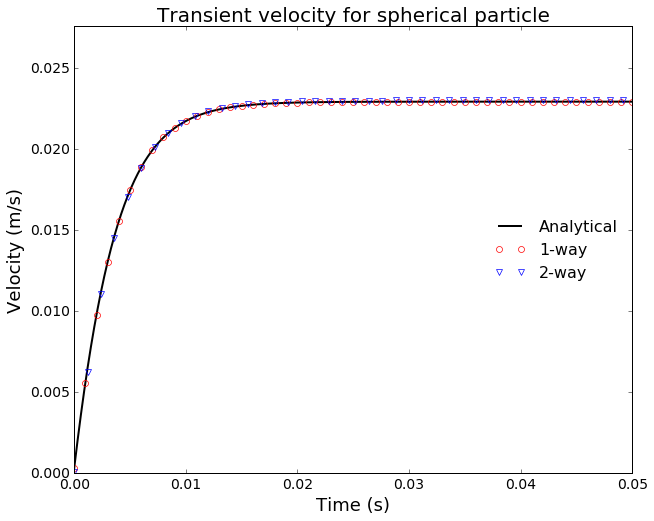

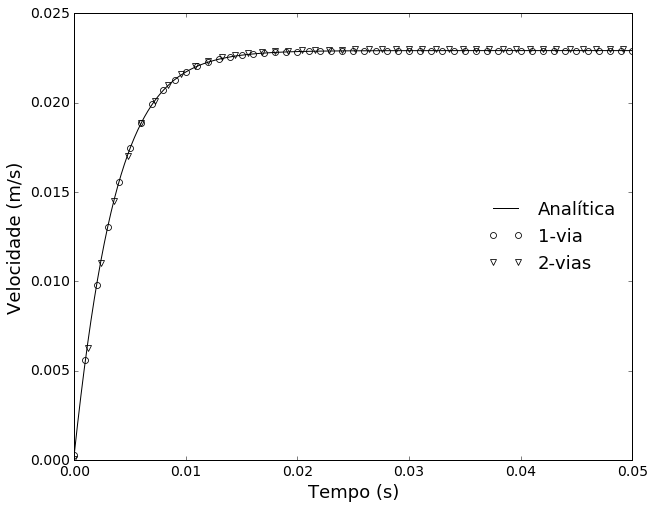

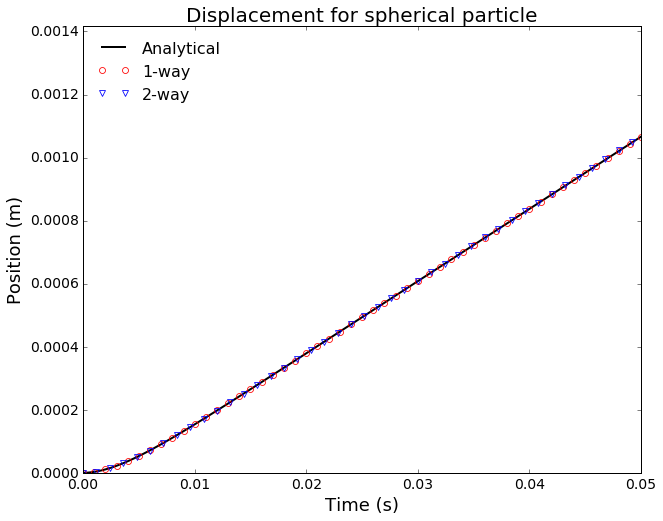

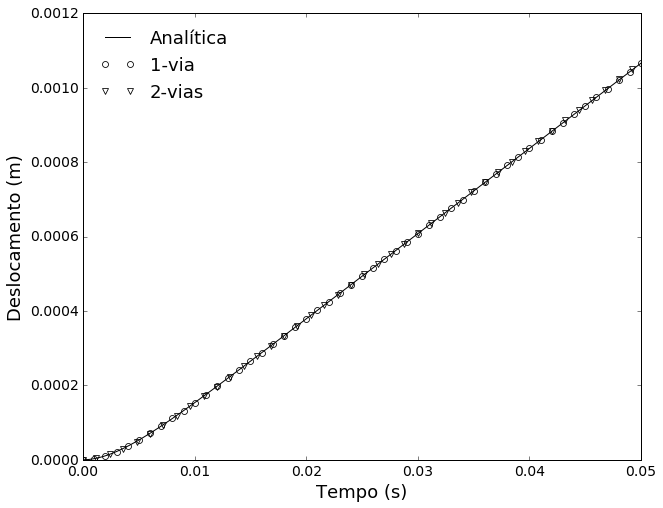

In [8]:
# fluid properties
rho_f = 1000 # [kg/m³]
mu_f = 0.001 # [Pa s]
cartc_time = mass/(3*np.pi*mu_f*d_p)
regime = 1

# loading the digitized data
rocky_data_one_way = open("falling_particle1_way.csv", 'r')
date_one_way, particlez_one_way, velocity_one_way, displacement_one_way, time_one_way = np.loadtxt(rocky_data_one_way, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way.close()

rocky_data_two_way = open("falling_particle_2_way-radius100.csv", 'r')
date_two_way, particlez_two_way, velocity_two_way, displacement_two_way, time_two_way = np.loadtxt(rocky_data_two_way, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_two_way.close()


print("Terminal velocity using Stokes =", StokesTerminalVelocity(rho_s, rho_f, g, d_p, mu_f),  "[m/s] ")
print("Terminal velocity using Newtonian =", NewtonianDragTerminalVelocity(rho_s, rho_f, g, d_p),  "[m/s] ")

print("\n Terminal velocity calculations: \n")
v_inf = fsolve(residual, 0.1)[0]

print("Particle terminal velocity =", v_inf, "[m/s] ")

print("Transient velocity calculations: \n")


#integrating to get velocity
vel_water_one_way = scipy.integrate.odeint(transient_velocity, velocity_one_way[0], time_one_way, (regime,))
vel_water_two_way = scipy.integrate.odeint(transient_velocity, velocity_two_way[0], time_two_way, (regime,))

# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(time_one_way,vel_water_one_way, linewidth = 2, color = "black", label = "Analytical")
plt.plot(time_one_way, velocity_one_way, linestyle = "None", marker = 'o', markeredgecolor = "red",  markeredgewidth = 0.7, markevery=10, 
           markerfacecolor = "none", label = r"1-way")
plt.plot(time_two_way, velocity_two_way, linestyle = "None", marker = 'v', markeredgecolor = "blue",  markeredgewidth = 0.7, markevery=12, 
           markerfacecolor = "none", label = r"2-way")


plt.xlabel('Time (s)',  fontsize = 18)
plt.ylabel('Velocity (m/s)',  fontsize = 18)
plt.title("Transient velocity for spherical particle", fontsize = 20)
plt.legend(fontsize = 16, loc='center right', frameon = False)
#plt.xlim(xmax = time_water[-1], xmin = 0)
plt.xlim(xmax = 0.05, xmin = 0)
plt.ylim(ymax = 1.2*velocity_one_way[-1], ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('velocity_water.png')
plt.show()

# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(time_one_way,vel_water_one_way, linewidth = 1, color = "black", label = "Analítica")
plt.plot(time_one_way, velocity_one_way, linestyle = "None", marker = 'o', markeredgecolor = "black",  markeredgewidth = 0.8, markevery=10, 
           markerfacecolor = "none", label = r"1-via")
plt.plot(time_two_way, velocity_two_way, linestyle = "None", marker = 'v', markeredgecolor = "black",  markeredgewidth = 0.8, markevery=12, 
           markerfacecolor = "none", label = r"2-vias")


plt.xlabel('Tempo (s)',  fontsize = 18)
plt.ylabel('Velocidade (m/s)',  fontsize = 18)
#plt.title("", fontsize = 20)
plt.legend(fontsize = 18, loc='center right', frameon = False)
#plt.xlim(xmax = time_water[-1], xmin = 0)
plt.xlim(xmax = 0.05, xmin = 0)
plt.ylim(ymax = 0.025, ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('velocidade_agua.png')
plt.show()




#integrating to get position
position_water_one_way =  scipy.integrate.cumtrapz(vel_water_one_way.T, time_one_way, initial = displacement_one_way[0])
position_water_two_way =  scipy.integrate.cumtrapz(vel_water_two_way.T, time_two_way, initial = displacement_two_way[0])

plt.plot(time_one_way, position_water_one_way.T, linewidth = 2, color = "black", label = "Analytical")
plt.plot(time_one_way, displacement_one_way, linestyle = "None",  marker = 'o', markeredgecolor = "red", markeredgewidth = 0.8,  markevery=10, 
           markerfacecolor = "none", label = r"1-way")
plt.plot(time_two_way, displacement_two_way, linestyle = "None", marker = 'v', markeredgecolor = "blue",  markeredgewidth = 0.8, markevery=12, 
           markerfacecolor = "none", label = r"2-way")

plt.xlabel('Time (s)',  fontsize = 18)
plt.ylabel('Position (m)',  fontsize = 18)
plt.title("Displacement for spherical particle", fontsize = 20)
plt.legend(fontsize = 16, loc='upper left', frameon = False)
#plt.xlim(xmax = time_water[-1], xmin = 0)
plt.xlim(xmax = 0.05, xmin = 0)
plt.ylim(ymax = 0.65*displacement_one_way[-1], ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('displacement_water.png')
plt.show()

plt.plot(time_one_way, position_water_one_way.T, linewidth = 1, color = "black", label = "Analítica")
plt.plot(time_one_way, displacement_one_way, linestyle = "None",  marker = 'o', markeredgecolor = "black", markeredgewidth = 0.8,  markevery=10, 
           markerfacecolor = "none", label = r"1-via")
plt.plot(time_two_way, displacement_two_way, linestyle = "None", marker = 'v', markeredgecolor = "black",  markeredgewidth = 0.8, markevery=12, 
           markerfacecolor = "none", label = r"2-vias")

plt.xlabel('Tempo (s)',  fontsize = 18)
plt.ylabel('Deslocamento (m)',  fontsize = 18)
#plt.title("Displacement for spherical particle", fontsize = 20)
plt.legend(fontsize = 18, loc='upper left', frameon = False)
#plt.xlim(xmax = time_water[-1], xmin = 0)
plt.xlim(xmax = 0.05, xmin = 0)
plt.ylim(ymax = 0.0012, ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('deslocamento_agua.png')
plt.show()


 
 10% Terminal velocity:  0.00229168303025


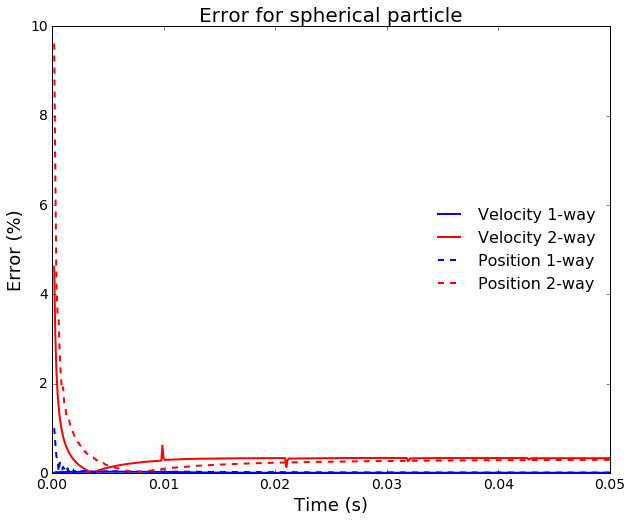

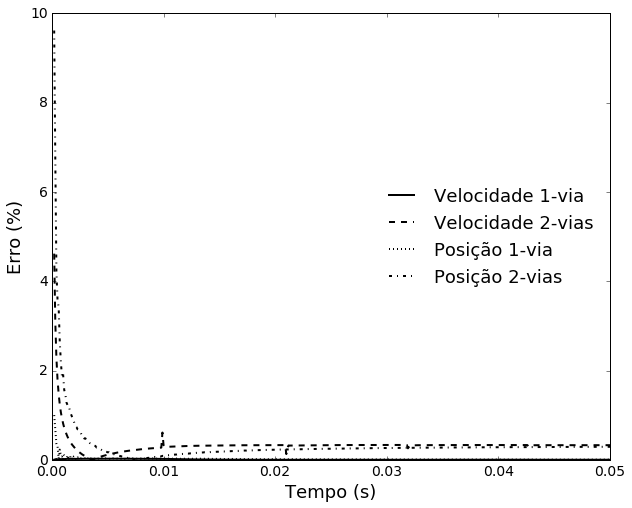

In [9]:
#error calculations

print(" \n 10% Terminal velocity: ", v_inf*0.1)
limiting_velocity = v_inf*0.05


limited_time_one_way = time_one_way[np.argmax(vel_water_one_way>limiting_velocity):]
limited_time_two_way = time_two_way[np.argmax(vel_water_two_way>limiting_velocity):]

limited_vel_anal_one_way = vel_water_one_way[np.argmax(vel_water_one_way>limiting_velocity):]
limited_vel_one_way = velocity_one_way.reshape((velocity_one_way.size, 1))[np.argmax(vel_water_one_way>limiting_velocity):]

limited_vel_anal_two_way = vel_water_two_way[np.argmax(vel_water_two_way>limiting_velocity):]
limited_vel_two_way = velocity_two_way.reshape((velocity_two_way.size, 1))[np.argmax(vel_water_two_way>limiting_velocity):]

limited_pos_anal_one_way = position_water_one_way.T[np.argmax(vel_water_one_way>limiting_velocity):]
limited_pos_one_way = displacement_one_way.reshape((displacement_one_way.size, 1))[np.argmax(vel_water_one_way>limiting_velocity):]

limited_pos_anal_two_way = position_water_two_way.T[np.argmax(vel_water_two_way>limiting_velocity):]
limited_pos_two_way = displacement_two_way.reshape((displacement_two_way.size, 1))[np.argmax(vel_water_two_way>limiting_velocity):]


error_vel_water_1_way = np.absolute(100*(limited_vel_anal_one_way - limited_vel_one_way)/limited_vel_anal_one_way)
error_vel_water_2_way = np.absolute(100*(limited_vel_anal_two_way - limited_vel_two_way)/limited_vel_anal_two_way)

error_pos_water_1_way = np.absolute(100*(limited_pos_anal_one_way - limited_pos_one_way)/limited_pos_anal_one_way)
error_pos_water_2_way = np.absolute(100*(limited_pos_anal_two_way - limited_pos_two_way)/limited_pos_anal_two_way)


plt.plot(limited_time_one_way,error_vel_water_1_way, linewidth = 2, color = "blue", linestyle= '-', label = "Velocity 1-way")
plt.plot(limited_time_two_way,error_vel_water_2_way, linewidth = 2, color = "red", linestyle= '-', label = "Velocity 2-way")
plt.plot(limited_time_one_way,error_pos_water_1_way, linewidth = 2, color = "blue", linestyle= '--', label = "Position 1-way")
plt.plot(limited_time_two_way,error_pos_water_2_way, linewidth = 2, color = "red", linestyle= '--', label = "Position 2-way")
plt.xlabel('Time (s)',  fontsize = 18)
plt.ylabel('Error (%)',  fontsize = 18)
plt.title("Error for spherical particle", fontsize = 20)
plt.legend(fontsize = 16, loc='center right', frameon = False)
#plt.xlim(xmax = time_two_way.max(), xmin = 0)
plt.xlim(xmax = 0.05, xmin = 0)
plt.ylim(ymax = 10, ymin = error_vel_water_1_way.min())
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('error_falling_particle_water.png')
plt.show()

plt.plot(limited_time_one_way,error_vel_water_1_way, linewidth = 2, color = "black", linestyle= '-', label = "Velocidade 1-via")
plt.plot(limited_time_two_way,error_vel_water_2_way, linewidth = 2, color = "black", linestyle= '--', label = "Velocidade 2-vias")
plt.plot(limited_time_one_way,error_pos_water_1_way, linewidth = 2, color = "black", linestyle= ':', label = "Posição 1-via")
plt.plot(limited_time_two_way,error_pos_water_2_way, linewidth = 2, color = "black", linestyle= '-.', label = "Posição 2-vias")
plt.xlabel('Tempo (s)',  fontsize = 18)
plt.ylabel('Erro (%)',  fontsize = 18)
#plt.title("Error for spherical particle", fontsize = 20)
plt.legend(fontsize = 18, loc='center right', frameon = False)
#plt.xlim(xmax = time_two_way.max(), xmin = 0)
plt.xlim(xmax = 0.05, xmin = 0)
plt.ylim(ymax = 10, ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('erro_particula_na_agua.png')
plt.show()
